In [20]:

import pandas as pd
import numpy as np

# Load your cleaned data
df = pd.read_csv('../data/raw/data.csv')



In [21]:
# Aggregate features
agg_features = df.groupby('CustomerId').agg(
    total_transaction_amount=('Amount', 'sum'),
    average_transaction_amount=('Amount', 'mean'),
    transaction_count=('Amount', 'count'),
    transaction_std=('Amount', 'std')
).reset_index()

# Merge with the original dataframe
df = pd.merge(df, agg_features, on='CustomerId', how='left')


In [22]:
# Convert TransactionStartTime to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Extract time-based features
df['TransactionHour'] = df['TransactionStartTime'].dt.hour
df['TransactionDay'] = df['TransactionStartTime'].dt.day
df['TransactionMonth'] = df['TransactionStartTime'].dt.month
df['TransactionYear'] = df['TransactionStartTime'].dt.year


In [23]:
df = pd.get_dummies(df, columns=['ChannelId', 'ProductCategory'], drop_first=True)


In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['CurrencyCode_encoded'] = le.fit_transform(df['CurrencyCode'])


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Amount', 'total_transaction_amount']] = scaler.fit_transform(df[['Amount', 'total_transaction_amount']])


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Amount', 'transaction_std']] = scaler.fit_transform(df[['Amount', 'transaction_std']])


In [27]:
# Define a threshold for RFMS score (e.g., average transaction amount and count)
df['RFMS_Score'] = (df['average_transaction_amount'] + df['transaction_count']) / 2

# Classify users as good (1) or bad (0)
df['Risk_Label'] = np.where(df['RFMS_Score'] > df['RFMS_Score'].mean(), 1, 0)


In [30]:
print(df.columns)


Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'Amount',
       'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'total_transaction_amount', 'average_transaction_amount',
       'transaction_count', 'transaction_std', 'TransactionHour',
       'TransactionDay', 'TransactionMonth', 'TransactionYear',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_5', 'ProductCategory_data_bundles',
       'ProductCategory_financial_services', 'ProductCategory_movies',
       'ProductCategory_other', 'ProductCategory_ticket',
       'ProductCategory_transport', 'ProductCategory_tv',
       'ProductCategory_utility_bill', 'CurrencyCode_encoded', 'RFMS_Score',
       'Risk_Label'],
      dtype='object')


In [43]:


def calculate_woe_iv(data, feature, target):
    """
    Calculate WoE and IV for a given feature (binary indicator).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the feature and target variable.
        feature (str): The feature column to calculate WoE and IV for.
        target (str): The binary target variable (e.g., 0 for good, 1 for bad).
    
    Returns:
        pd.DataFrame: DataFrame containing WoE and IV values for the feature.
        float: The total Information Value (IV) for the feature.
    """
    # Total counts of good (0) and bad (1) outcomes
    total_good = (data[target] == 0).sum()
    total_bad = (data[target] == 1).sum()
    
    # Aggregate data by the feature
    woe_table = data.groupby(feature).agg(
        good=(target, lambda x: (1 - x).sum()),  # Count of good (target == 0)
        bad=(target, lambda x: x.sum())         # Count of bad (target == 1)
    )
    
    # Calculate proportions
    woe_table['dist_good'] = woe_table['good'] / total_good
    woe_table['dist_bad'] = woe_table['bad'] / total_bad
    
    # Avoid division by zero for WoE calculation
    woe_table['dist_bad'] = woe_table['dist_bad'].replace(0, 0.0001)
    woe_table['dist_good'] = woe_table['dist_good'].replace(0, 0.0001)
    
    # Calculate WoE and IV
    woe_table['WoE'] = np.log(woe_table['dist_good'] / woe_table['dist_bad'])
    woe_table['IV'] = (woe_table['dist_good'] - woe_table['dist_bad']) * woe_table['WoE']
    
    # Total IV for the feature
    total_iv = woe_table['IV'].sum()
    
    return woe_table, total_iv

# List of one-hot encoded columns for ChannelId
channel_features = ['ChannelId_ChannelId_2', 'ChannelId_ChannelId_3', 'ChannelId_ChannelId_5']
target = 'Risk_Label'  # Binary target variable

# Calculate WoE and IV for each one-hot encoded column
for feature in channel_features:
    print(f"\nCalculating WoE and IV for feature: {feature}")
    woe_table, total_iv = calculate_woe_iv(df, feature, target)
    print(f"WoE Table for {feature}:\n{woe_table}\n")
    print(f"Total IV for {feature}: {total_iv}\n")



Calculating WoE and IV for feature: ChannelId_ChannelId_2
WoE Table for ChannelId_ChannelId_2:
                        good   bad  dist_good  dist_bad       WoE        IV
ChannelId_ChannelId_2                                                      
False                  52062  6459   0.600623  0.719105 -0.180040  0.021331
True                   34618  2523   0.399377  0.280895  0.351925  0.041697

Total IV for ChannelId_ChannelId_2: 0.0630281384407648


Calculating WoE and IV for feature: ChannelId_ChannelId_3
WoE Table for ChannelId_ChannelId_3:
                        good   bad  dist_good  dist_bad       WoE        IV
ChannelId_ChannelId_3                                                      
False                  35976  2751   0.415044  0.306279  0.303887  0.033052
True                   50704  6231   0.584956  0.693721 -0.170533  0.018548

Total IV for ChannelId_ChannelId_3: 0.05160006460440697


Calculating WoE and IV for feature: ChannelId_ChannelId_5
WoE Table for ChannelId_Ch

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

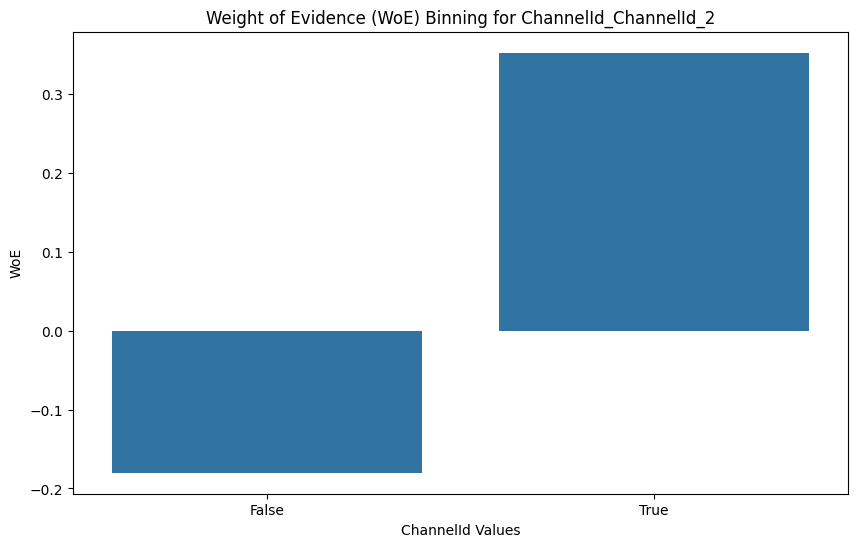

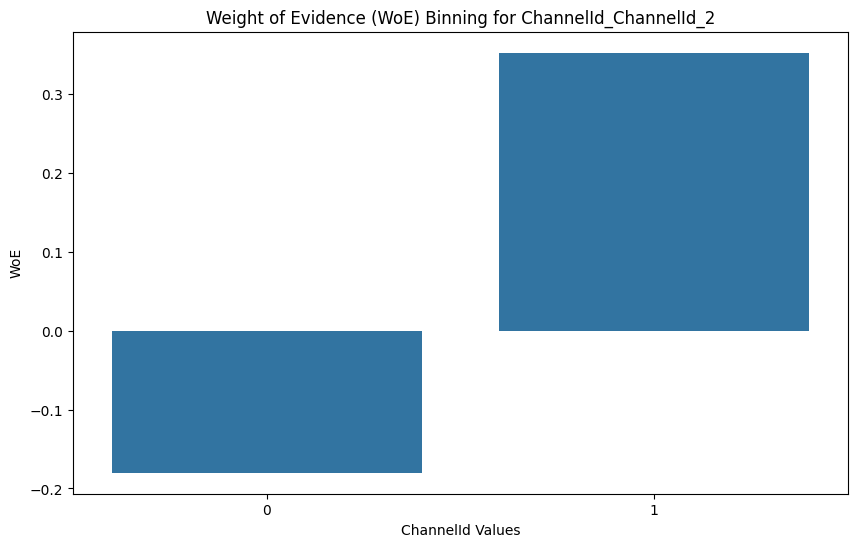

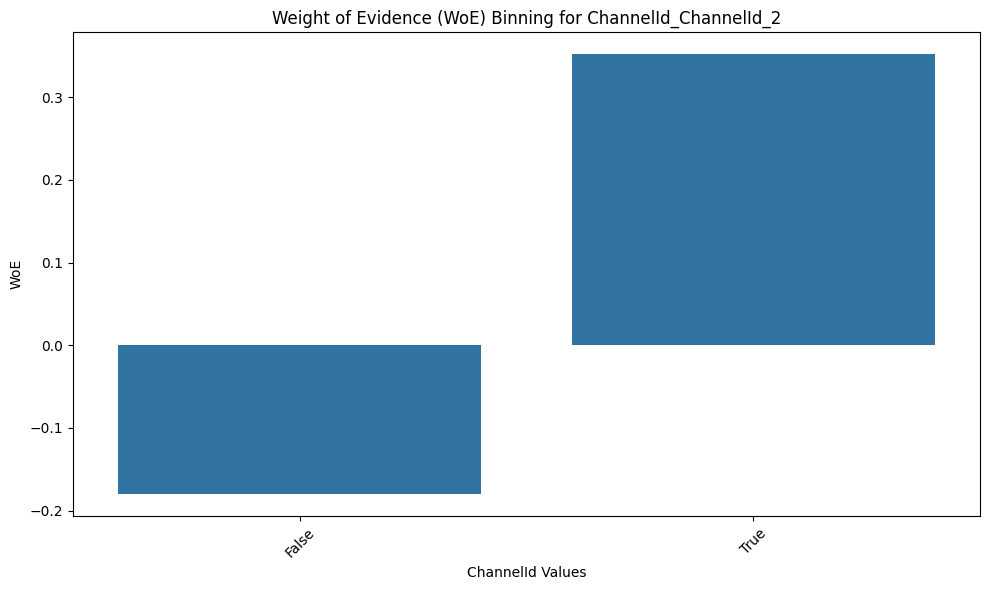

<Figure size 1000x600 with 0 Axes>

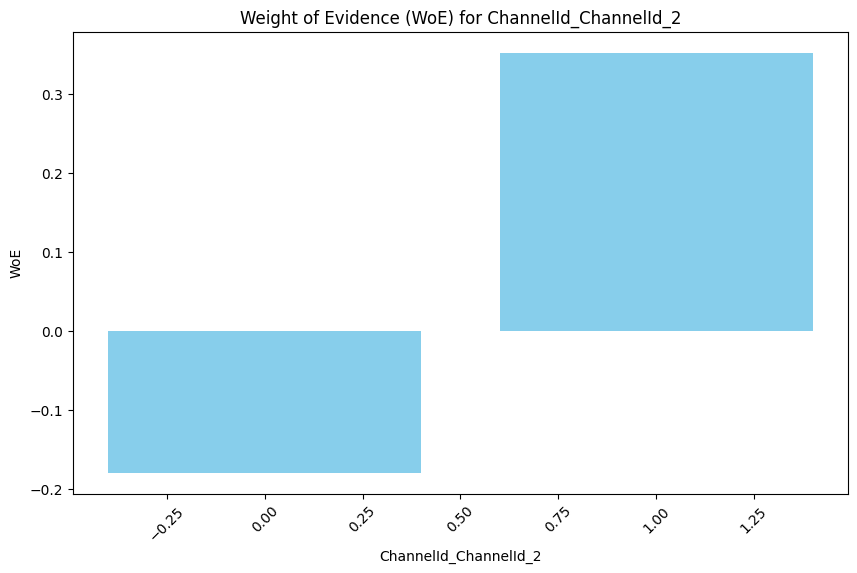

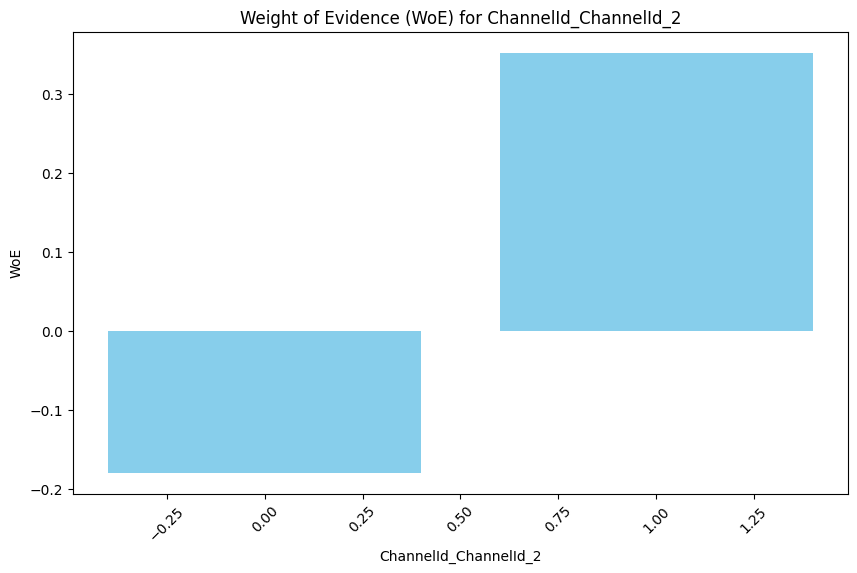

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot WoE values
woe_table.reset_index(inplace=True)
plt.figure(figsize=(10, 6))
plt.bar(woe_table[feature], woe_table['WoE'], color='skyblue')
plt.title(f"Weight of Evidence (WoE) for {feature}")
plt.xlabel(f"{feature}")
plt.ylabel("WoE")
plt.xticks(rotation=45)
plt.show()
